In [808]:
library(tidyverse)

In [809]:
data <- read_csv("atp2017-2019.csv")
data

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275
6,2019-M020,Brisbane,Hard,32,A,20181231,294,105453,2,⋯,53,37,13,12,6,9,9,3590,19,1835
7,2019-M020,Brisbane,Hard,32,A,20181231,293,104542,NA,⋯,51,34,11,11,6,11,239,200,77,691
8,2019-M020,Brisbane,Hard,32,A,20181231,292,200282,7,⋯,39,30,3,9,3,6,31,1298,72,715


In [810]:
# data <- select(data, winner_name, winner_hand, winner_ht, winner_ioc, winner_age, loser_name, loser_hand, loser_ht, loser_ioc, loser_age)%>%
#     filter(!is.na(winner_ht), !is.na(winner_age), !is.na(winner_ioc), !is.na(winner_hand), !is.na(loser_ht), !is.na(loser_age), !is.na(loser_ioc), !is.na(loser_hand))%>%
#     mutate(winner_hand = as_factor(winner_hand), winner_ioc = as_factor(winner_ioc), loser_hand = as_factor(loser_hand), loser_ioc = as_factor(loser_ioc))
    
# data

data <- select(data, tourney_date, winner_name, winner_hand, winner_ht, winner_ioc, winner_age, winner_rank)%>%
    filter(!is.na(winner_ht), !is.na(winner_rank), !is.na(winner_age), !is.na(winner_ioc), !is.na(winner_hand))%>%
    mutate(winner_hand = as_factor(winner_hand), winner_ioc = as_factor(winner_ioc), winner_rank = as.double(winner_rank))%>%
    distinct()
data

tourney_date,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank
<dbl>,<chr>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
20181231,Kei Nishikori,R,178,JPN,29.00479,9
20181231,Jo Wilfried Tsonga,R,188,FRA,33.70568,239
20181231,Jeremy Chardy,R,188,FRA,31.88227,40
20181231,Milos Raonic,R,196,CAN,28.01095,18
20181231,Grigor Dimitrov,R,188,BUL,27.62765,19
20181231,Andy Murray,R,190,GBR,31.63039,240
20181231,Nick Kyrgios,R,193,AUS,23.67967,35
20181231,John Millman,R,183,AUS,29.54689,38
20181231,Denis Kudla,R,180,USA,26.37098,63


In [811]:
# library(stringi)
# data <- mutate(data, year = substr(data$tourney_date, 0, 4))%>%
#     select(winner_name:year)%>%
#     mutate(year = as_factor(year))

data <- data%>%
    group_by(winner_name, winner_hand, winner_ht, winner_ioc)%>%
    summarize(number_of_wins = n(), winner_avg_age = mean(winner_age), winner_avg_rank = mean(winner_rank))%>%
    select(winner_name, winner_hand, winner_ht, winner_ioc, winner_avg_age, winner_avg_rank)
data <- mutate(data, winner_avg_age = round(winner_avg_age, 2))
data <- mutate(data, winner_avg_rank = round(winner_avg_rank, 2))
data


`summarise()` regrouping output by 'winner_name', 'winner_hand', 'winner_ht' (override with `.groups` argument)



winner_name,winner_hand,winner_ht,winner_ioc,winner_avg_age,winner_avg_rank
<chr>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
Adrian Mannarino,L,183,FRA,30.00,42.29
Albert Ramos,L,188,ESP,30.27,46.52
Alessandro Giannessi,L,183,ITA,27.39,137.00
Alexander Zverev,R,198,GER,21.11,7.51
Aljaz Bedene,R,181,SLO,28.80,66.42
Andreas Seppi,R,190,ITA,34.23,65.03
Andrej Martin,R,180,SVK,28.72,139.67
Andy Murray,R,190,GBR,31.05,209.12
Attila Balazs,R,180,HUN,30.28,191.00


In [812]:
library(repr)
library(tidymodels)
set.seed(9999) 

# Randomly take 75% of the data in the training set

data_split <- initial_split(data, prop = 0.75)
data_train <- training(data_split)   
data_test <- testing(data_split)

data_train

winner_name,winner_hand,winner_ht,winner_ioc,winner_avg_age,winner_avg_rank
<chr>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
Albert Ramos,L,188,ESP,30.27,46.52
Aljaz Bedene,R,181,SLO,28.80,66.42
Andrej Martin,R,180,SVK,28.72,139.67
Bernard Tomic,R,193,AUS,25.60,97.85
Blaz Kavcic,R,188,SLO,31.12,143.50
Bradley Klahn,L,190,USA,28.50,108.00
Cedrik Marcel Stebe,L,183,GER,27.62,269.57
Damir Dzumhur,R,172,BIH,25.86,56.73
Daniel Brands,R,196,GER,31.55,180.00


In [835]:
data_train_summarize <- data_train%>%
    tibble(number_of_players = 81, number_of_right_handed = 71, number_of_left_handed = 10, max_height = max(winner_ht), min_height = min(winner_ht), mean_height = mean(winner_ht),
          number_of_nationalities = 33, max_age = max(winner_avg_age), min_age = min(winner_avg_age), mean_age = mean(winner_avg_age), top = "Rafael Nadal", bottom = "James Duckworth")%>%
    select(number_of_players:bottom)%>%
    slice(1)
data_train_summarize

number_of_winner_hand <- data_train%>%
    group_by(winner_hand)%>%
    summarize(n())
number_of_winner_hand

nationality_analysis <- data_train%>%
    group_by(winner_ioc)%>%
    summarize(number = n())%>%
    nrow()
nationality_analysis

ranking <- data_train%>%
    group_by(winner_name)%>%
    summarize(winner_avg_rank)%>%
    arrange(winner_avg_rank)%>%
    slice(1, 81)
ranking

number_of_players,number_of_right_handed,number_of_left_handed,max_height,min_height,mean_height,number_of_nationalities,max_age,min_age,mean_age,top,bottom
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
81,71,10,208,170,186.1481,33,39.08,24.18,30.3358,Rafael Nadal,James Duckworth


`summarise()` ungrouping output (override with `.groups` argument)



winner_hand,n()
<fct>,<int>
R,71
L,10


`summarise()` ungrouping output (override with `.groups` argument)



[1] 33

`summarise()` ungrouping output (override with `.groups` argument)



winner_name,winner_avg_rank
<chr>,<dbl>
Rafael Nadal,2.48
James Duckworth,654.00


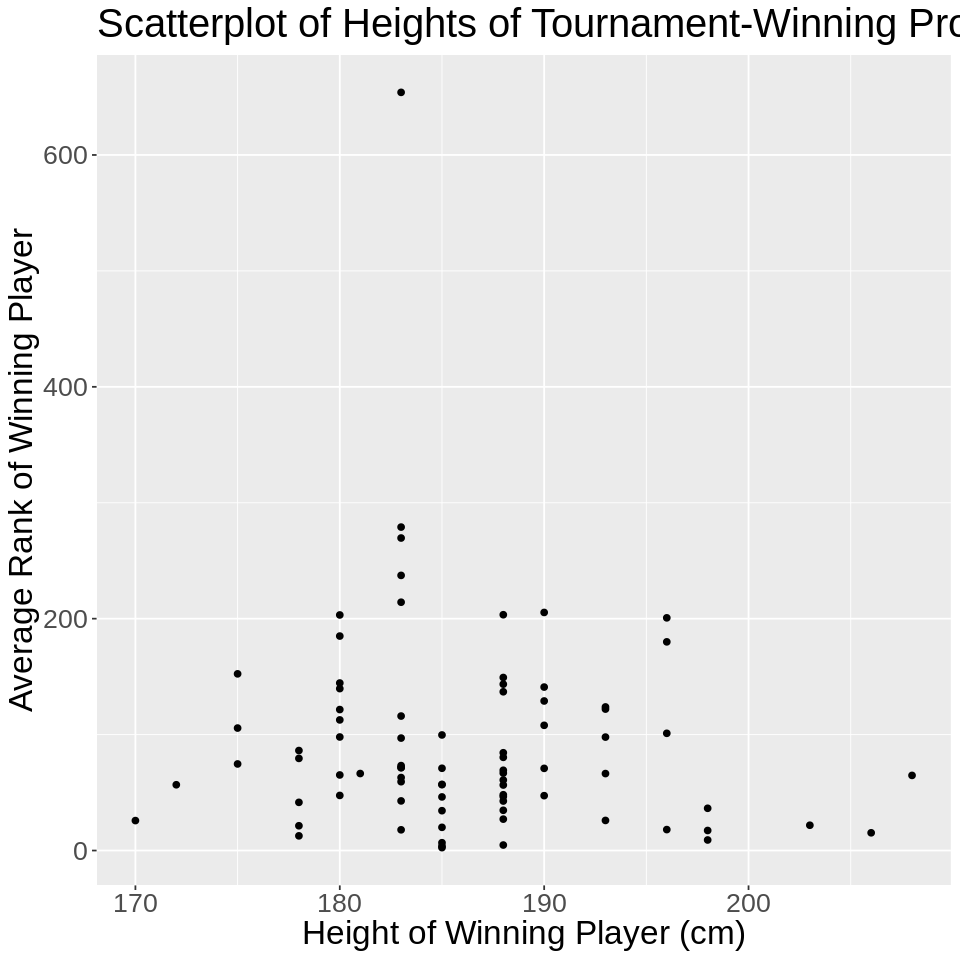

In [848]:
options(repr.plot.width = 8, repr.plot.height = 8)
data_train_scatterplot <- data_train%>%
    ggplot(aes(x=winner_ht, y=winner_avg_rank))+
        geom_point(position = "identity")+
        labs(x="Height of Winning Player (cm)", y="Average Rank of Winning Player")+
        ggtitle("Scatterplot of Heights of Tournament-Winning Professional Tennis Players (cm) Against their Average Rank Over Three Years (2017 - 2019)")+
        theme (text = element_text (size = 20))
data_train_scatterplot